In [70]:
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.python.keras.layers import Conv3D, ReLU, MaxPooling3D, Reshape, Dense, Dropout, SeparableConv2D, MaxPooling2D, Conv2D
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Bidirectional, Flatten, LSTM
from tensorflow.python.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from frame_extraction import Frames

## Frame extraction class

In [17]:
class Frames_V2(Frames):
    @classmethod
    def read_fr(cls, arr):
        videos = []
        for index, video in enumerate(arr):
            print("Completed", round(index / len(arr) * 100, 2), end="\r")

            caption = cv2.VideoCapture(video)
            frame_rate = caption.get(Frames.fps)

            while caption.isOpened():
                frame_id = caption.get(1)
                ret, frame = caption.read()

                if not ret:
                    break

                if frame_id % np.floor(frame_rate) == 0:
                    videos.append(cv2.resize(frame, (64, 64)))

            caption.release()

        return videos

In [2]:
classes = ["NonViolence", "Violence"]

In [4]:
file_list = []
for name in classes:
    file_names = glob.glob(f"dataset/Real Life Violence Dataset/{name}/*.*")
    file_list.extend(file_names)

## Pre processing dataset

In [37]:
# violence dataset
violence = list(filter(lambda x: "/violence" in x.lower(), file_list))

In [39]:
non_violence = list(filter(lambda x: "/nonviolence" in x.lower(), file_list))

In [41]:
violence_arr = Frames_V2.read_fr(violence)

In [42]:
non_violence_arr = Frames_V2.read_fr(non_violence)

In [50]:
violence_arr = np.asarray(violence_arr)
non_violence_arr = np.asarray(non_violence_arr)

In [51]:
# Training data
X = np.concatenate((violence_arr, non_violence_arr), axis=0)

### 1 is meant for violence and 0 is meant for non violence

In [52]:
Y = np.array([1 for _ in range(violence_arr.shape[0])] + [0 for _ in range(non_violence_arr.shape[0])])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

## Creating model

In [71]:
Model = Sequential()

Model.add(SeparableConv2D(12,(3,3),activation="relu",
                 input_shape=(64,64,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

#
Model.add(SeparableConv2D(24,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.2))
Model.add(MaxPooling2D((2,2)))


#
Model.add(TimeDistributed(Flatten()))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))

#
Model.add(Flatten())
Model.add(Dense(128,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(1,activation="sigmoid"))

In [72]:
Model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_16 (Separab (None, 62, 62, 12)        75        
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 62, 62, 12)        48        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 12)        0         
_________________________________________________________________
separable_conv2d_17 (Separab (None, 31, 31, 24)        420       
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 24)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 24)        0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 15, 360)          

In [73]:
Model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [74]:
Model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=7)

Epoch 1/7
885/885 [==============================] - 77s 72ms/step - loss: 0.5455 - accuracy: 0.7154 - val_loss: 0.4897 - val_accuracy: 0.7429
Epoch 2/7
885/885 [==============================] - 61s 69ms/step - loss: 0.4064 - accuracy: 0.8129 - val_loss: 0.3489 - val_accuracy: 0.8409
Epoch 3/7
885/885 [==============================] - 64s 72ms/step - loss: 0.3514 - accuracy: 0.8422 - val_loss: 0.3071 - val_accuracy: 0.8581
Epoch 4/7
885/885 [==============================] - 64s 72ms/step - loss: 0.2997 - accuracy: 0.8717 - val_loss: 0.2562 - val_accuracy: 0.8920
Epoch 5/7
885/885 [==============================] - 63s 71ms/step - loss: 0.2664 - accuracy: 0.8861 - val_loss: 0.2343 - val_accuracy: 0.9015
Epoch 6/7
885/885 [==============================] - 63s 71ms/step - loss: 0.2299 - accuracy: 0.9053 - val_loss: 0.2543 - val_accuracy: 0.8934
Epoch 7/7
885/885 [==============================] - 62s 71ms/step - loss: 0.2092 - accuracy: 0.9161 - val_loss: 0.2287 - val_accuracy: 0.9024

In [77]:
Model.save("saved_model_v2")

INFO:tensorflow:Assets written to: saved_model_v2\assets


INFO:tensorflow:Assets written to: saved_model_v2\assets


In [78]:
loss, accuracy = Model.evaluate(X_test, y_test)

70/70 [==============================] - 2s 24ms/step - loss: 0.2287 - accuracy: 0.9024


In [80]:
print(f"Accuracy: {round(accuracy * 100, 3)} %")

Accuracy: 90.239 %


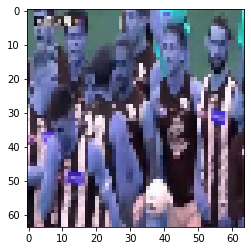

In [81]:
plt.imshow(X_test[0])

In [82]:
y_test[0]

0